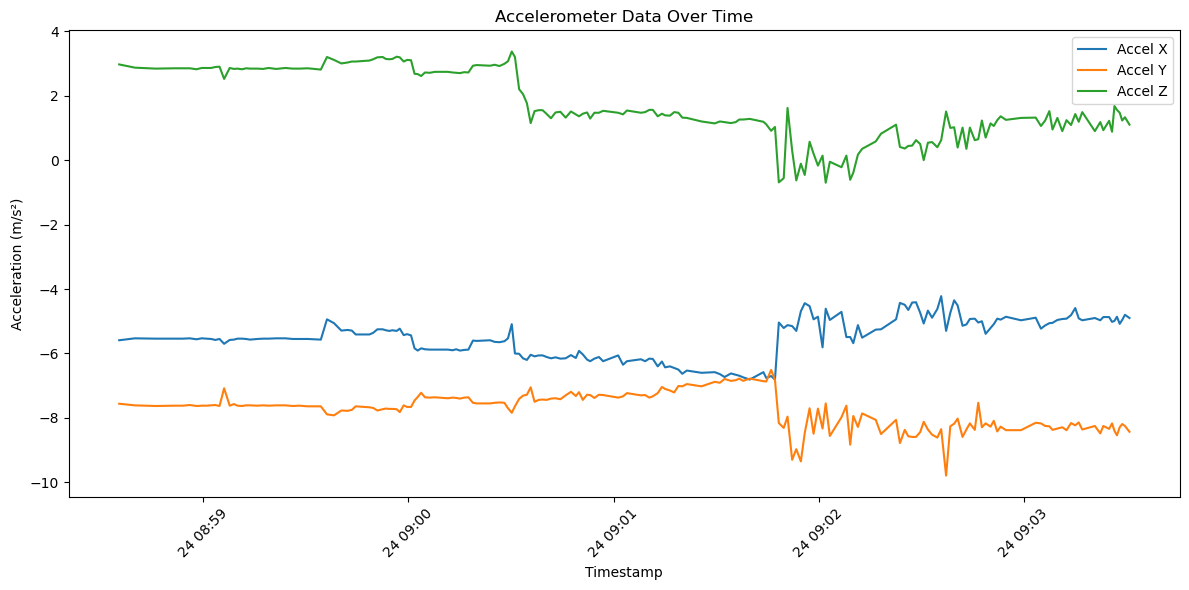

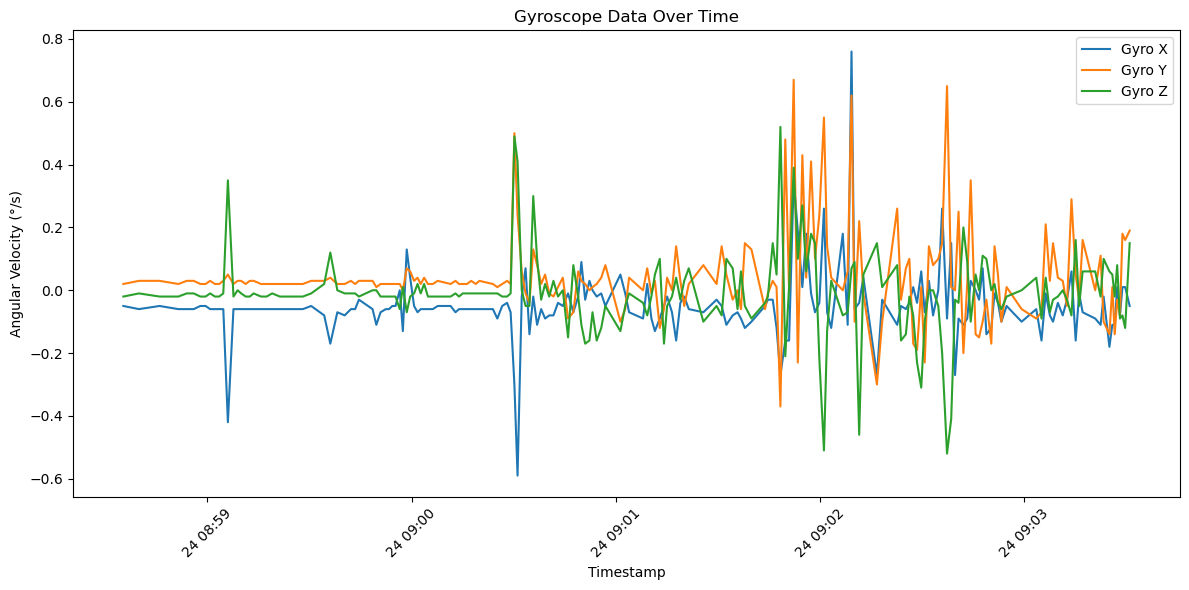

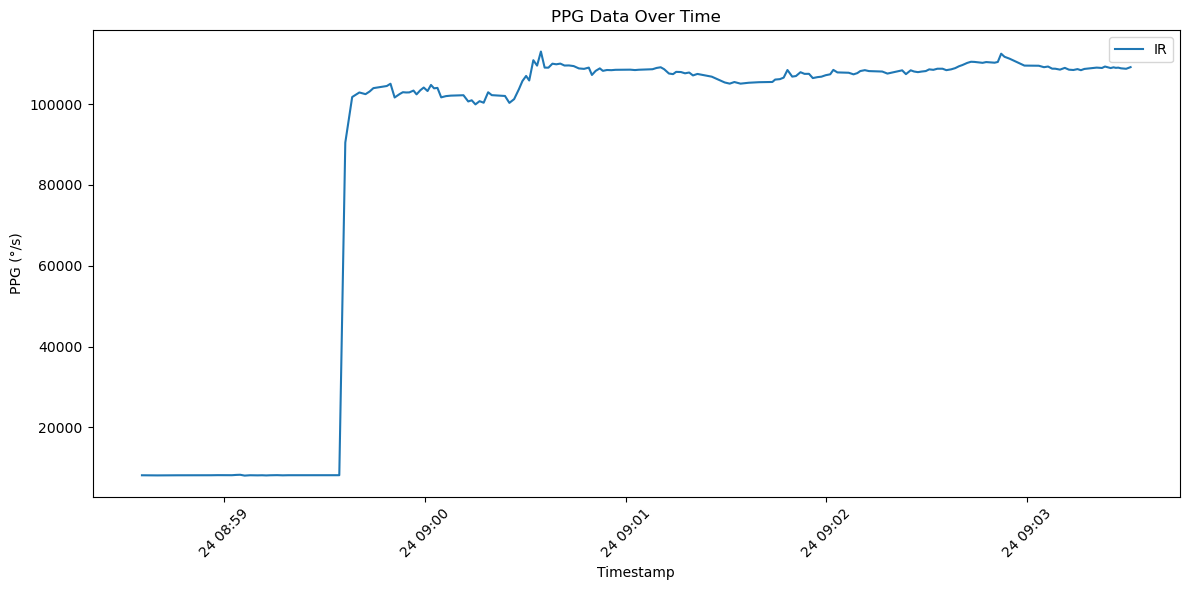

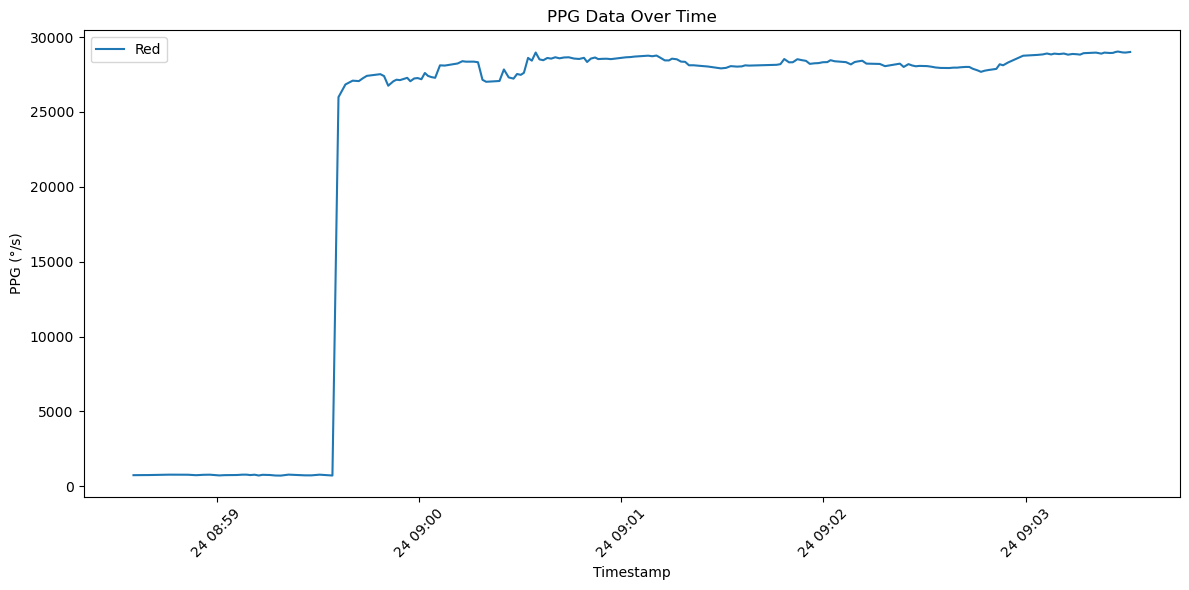

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data
data = pd.read_csv('mpu6050_max30102_data_20250224_085828.csv', parse_dates=['timestamp'])

# Plot accelerometer data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['AccelX'], label='Accel X')
plt.plot(data['timestamp'], data['AccelY'], label='Accel Y')
plt.plot(data['timestamp'], data['AccelZ'], label='Accel Z')
plt.xlabel('Timestamp')
plt.ylabel('Acceleration (m/s²)')
plt.title('Accelerometer Data Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot gyroscope data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['GyroX'], label='Gyro X')
plt.plot(data['timestamp'], data['GyroY'], label='Gyro Y')
plt.plot(data['timestamp'], data['GyroZ'], label='Gyro Z')
plt.xlabel('Timestamp')
plt.ylabel('Angular Velocity (°/s)')
plt.title('Gyroscope Data Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Plot gyroscope data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['IR'], label='IR')
plt.xlabel('Timestamp')
plt.ylabel('PPG (°/s)')
plt.title('PPG Data Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot gyroscope data
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['Red'], label='Red')
plt.xlabel('Timestamp')
plt.ylabel('PPG (°/s)')
plt.title('PPG Data Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
